In [33]:
import pandas as pd
import numpy as np
import requests

Edit the YourLibrary.json file to remove anything other than the tracks dict before this step

In [34]:
df_lib = pd.read_json('YourLibrary0.json')
df_lib['ID'] = df_lib['artist'] + ":" + df_lib['track']
new = df_lib["uri"].str.split(":", expand = True)
df_lib['track_uri'] = new[2]

Create the spotify dataframe

In [35]:
df_spotify = pd.read_json('StreamingHistory0.json')
df_spotify['ID'] = df_spotify['artistName'] + ":" + df_spotify['trackName']
df_spotify['In Library'] = np.where(df_spotify['ID'].isin(df_lib['ID'].tolist()),1,0)
df_spotify = pd.merge(df_spotify, df_lib[['album','ID']],how='left',on=['ID'])

Get the Client_ID and Client_secret from here https://developer.spotify.com/dashboard. Sign in and create a new app then you'll find the Client_ID and Client_secret.

In [36]:
Client_ID = '627f31b5a8d740d588a087cc4b12241b'
Client_secret = 'e6021b4f149249f5bea550510114b907'

Request authorization from spotify and get the access token

In [37]:
AUTH_URL = 'https://accounts.spotify.com/api/token'
auth_response = requests.post(AUTH_URL, {
    'grant_type': 'client_credentials',
    'client_id': Client_ID,
    'client_secret': Client_secret,
})
auth_response_data = auth_response.json()
access_token = auth_response_data['access_token']

Get the genres from spotify using the uri

In [38]:
headers = {'Authorization': 'Bearer {token}'.format(token=access_token)}
BASE_URL = 'https://api.spotify.com/v1/'

dict_genre = {}
track_uris = df_lib['track_uri'].to_list()
for t_uri in track_uris:
    
    dict_genre[t_uri] = {'artist_uri': "", "genres":[]}
    
    r = requests.get(BASE_URL + 'tracks/' + t_uri, headers=headers)
    r = r.json()
    a_uri = r['artists'][0]['uri'].split(':')[2]
    dict_genre[t_uri]['artist_uri'] = a_uri
    
    s = requests.get(BASE_URL + 'artists/' + a_uri, headers=headers)
    s = s.json()
    dict_genre[t_uri]['genres'] = s['genres']

Put the genres in a dataframe

In [39]:
df_genre = pd.DataFrame.from_dict(dict_genre, orient='index')
df_genre.insert(0, 'track_uri', df_genre.index)
df_genre.reset_index(inplace=True, drop=True)
df_genre = df_genre.explode('genres')
df_genre

,track_uri,artist_uri,genres
0,5o97IsOGSYy67xqIxSprpL,77qukKzmdI5BeMBR7WGUrN,chicago house
1,0e7ipj03S05BNilyu5bRzt,246dkjvS1zLTtiykXe5h60,dfw rap
1,0e7ipj03S05BNilyu5bRzt,246dkjvS1zLTtiykXe5h60,melodic rap
1,0e7ipj03S05BNilyu5bRzt,246dkjvS1zLTtiykXe5h60,rap
2,6GnhWMhgJb7uyiiPEiEkDA,4LLpKhyESsyAXpc4laK94U,hip hop
...,...,...,...
52,6MWtB6iiXyIwun0YzU6DFP,246dkjvS1zLTtiykXe5h60,dfw rap
52,6MWtB6iiXyIwun0YzU6DFP,246dkjvS1zLTtiykXe5h60,melodic rap
52,6MWtB6iiXyIwun0YzU6DFP,246dkjvS1zLTtiykXe5h60,rap
53,0ZlVUhjO8c0bOx1D2Btznf,4gzpq5DPGxSnKTe4SA8HAU,permanent wave


Create a wordcloud of the genres

In [9]:
from pathlib import Path
import wordcloud as wc
import matplotlib.pyplot as plt

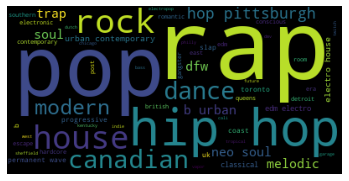

In [16]:
genres = ' '.join(df_genre['genres'].tolist())
cloud = wc.WordCloud()
genre_cloud = cloud.generate(genres)
plt.axis('off')
plt.imshow(genre_cloud)

Plot the music listening hours of the day

In [32]:
df_spotify['endTime'] = pd.to_datetime(df_spotify['endTime'])
df_spotify['endHour'] = df_spotify['endTime'].dt.strftime('%H')

listn_hrs = df_spotify[['endHour','msPlayed']]

df_lh = listn_hrs.groupby(['endHour']).mean()
df_lh

,msPlayed
endHour,
07,8133.916667
22,30262.818182
